VAEs dynamiques : https://arxiv.org/abs/2008.12595

# Training a GP-VAE

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [37]:
from libs.gpvae_lib import seed_everything, Encoder, GaussianDecoder, GaussianProcessPriorMaison, vlb

In [38]:
# Set seed for reproducibility
seed_everything(42)

In [39]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    dtype = torch.cuda.FloatTensor
else:
    device = torch.device('cpu')
    dtype = torch.FloatTensor

print(f"Using {device}")

torch.set_default_dtype(torch.float64)

if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Total GPU Memory:', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using cuda
GPU Name: NVIDIA GeForce RTX 4090
Total GPU Memory: 23.6 GB


# Modèle

### GP-VAE :

A écrire

# Parameters

In [40]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 1 # Dimension of the latent space

# Toy Case : Data Generation for Time Series Forecasting

In [41]:
n_steps = 1000
n_ahead = 10
n_series = 1000

def generate_time_series(batch_size, n_steps, noise=0.05):
    """Utility function to generate time series data.

    Args:
        batch_size (int): number of time series to generate (btach size)
        n_steps (_type_): length of each time series
    """
    
    f1,f2,o1,o2 = np.random.rand(4, batch_size, 1)  # return 4 values for each time series
    time = np.linspace(0, 1, n_steps)  # time vector
    
    series = 0.4 * np.sin((time - o1) * (f1 * 5 + 10)) # first sine wave
    series += 0.2 * np.sin((time - o2) * (f2 * 20 + 20)) # second sine wave
    series += noise * (np.random.randn(batch_size, n_steps) - 0.5)  # add noise
    
    return series

In [42]:
s = generate_time_series(n_series, n_steps+n_ahead)

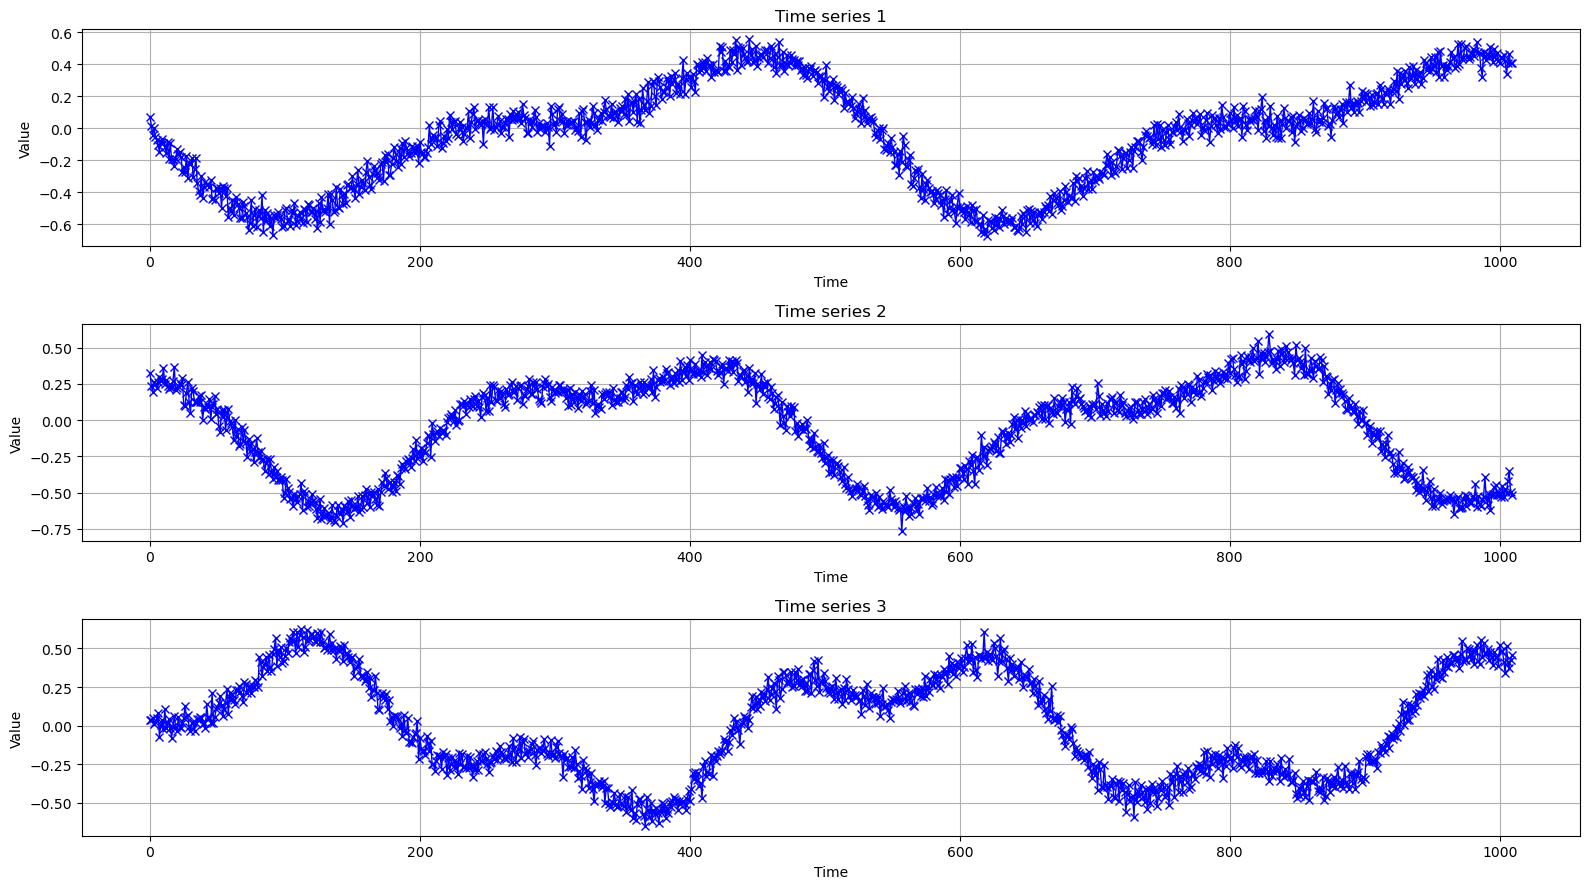

In [43]:
N = 3
fig, axs = plt.subplots(N, 1, figsize=(16, 3 * N))
for i in range(N):
    axs[i].plot(s[i], color='blue', marker="x", linewidth=1)
    axs[i].set_title(f"Time series {i+1}")
    axs[i].set_xlabel("Time")
    axs[i].set_ylabel("Value")
    axs[i].grid(True)
plt.tight_layout()
plt.show()

In [44]:
cutoff = int(0.8 * n_series)

X_train, y_train = s[:cutoff,:n_steps], s[:cutoff,n_steps:]
X_valid, y_valid = s[cutoff:,:n_steps], s[cutoff:,n_steps:]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_valid shape: {X_valid.shape}")
print(f"y_valid shape: {y_valid.shape}")

X_train shape: (800, 1000)
y_train shape: (800, 10)
X_valid shape: (200, 1000)
y_valid shape: (200, 10)


In [45]:
# form datasets, dataloaders, etc

BATCH_SIZE = 16  # 8192 ok sur RTX3080 et 150 time steps

from torch.utils.data import Dataset, DataLoader

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X).to(device)
        self.y = torch.tensor(y).to(device)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Baseline : RNN

In [46]:
class RNNModelLookAhead(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim, n_ahead=n_ahead, num_layers=1, batch_first=True, device=device, dtype=dtype):
        """Constructor for RNN.

        Args:
            input_dim (_type_): dimensionality of the input
            hidden_dim (_type_): dimensionality of the hidden state
            n_ahead (_type_, optional): number of time steps to predict. Defaults to N_AHEAD.
            output_dim (_type_, optional): dimensionality of the output.
            num_layers (int, optional): number of recurrent layers. Defaults to 1.
            batch_first (bool, optional): whether batch dim is first or not. Defaults to True.
                1. batch_first=True: (batch, seq, feature_dimension)
                2. batch_first=False: (seq, batch, feature_dimension)
            bidirectional (bool, optional): if True, becomes a bidriectional RNN. Defaults to False.
                1. bidirectional=True: num_directions=2, (batch, seq, hidden_dim * 2)
                2. bidirectional=False: num_directions=1, (batch, seq, hidden_dim)
            device (_type_, optional): _description_. Defaults to device.
            dtype (_type_, optional): _description_. Defaults to dtype.
        """
        super(RNNModelLookAhead, self).__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bidirectional = False
        self.n_ahead = n_ahead
        
        self.rnn = nn.RNN(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=batch_first,
            bidirectional=self.bidirectional
        )
        self.fc = nn.Linear(hidden_dim, n_ahead*output_dim)
    
    def forward(self, x):
        # first, initialize the hidden state
        h0 = torch.zeros((self.num_layers, x.size(0), self.hidden_dim), requires_grad=True).to(device)
        # INPUT : x : (batch, sequence_length, input_feature_dimension)
        x, _ = self.rnn(x, h0) 
        # OUTPUT: 
        # - output : (batch, sequence_length, hidden_dimension * num_directions)
        # - h_n : (num_layers * num_directions, batch, hidden_dimension) (hidden state for last time step)
        x = self.fc(x[:, -1, :])  # take the last time step
        x = x.view(-1, self.n_ahead, self.output_dim)
        # OUTPUT: x : (batch, output_dimension)
        return x

In [47]:
rnn = RNNModelLookAhead(
    input_dim=1,
    output_dim=1,
    n_ahead=n_ahead,
    hidden_dim=128,
    num_layers=4,
    batch_first=True,
    device=device,
    dtype=dtype
).to(device)

print(rnn)

RNNModelLookAhead(
  (rnn): RNN(1, 128, num_layers=4, batch_first=True)
  (fc): Linear(in_features=128, out_features=10, bias=True)
)


In [48]:
# Test dimensions

x = torch.randn(BATCH_SIZE, 50, 1).to(device)
y = rnn(x)
print(f"input shape: {x.shape}")
print(f"output shape: {y.shape}")

input shape: torch.Size([16, 50, 1])
output shape: torch.Size([16, 10, 1])


In [49]:
criterion = nn.MSELoss()

In [50]:
lr = 1e-4
optimizer = torch.optim.Adam(rnn.parameters(), lr=lr)
num_epochs = 30

In [51]:
train_losses = []
valid_losses = []

print(f"Start training RNN model for {num_epochs} epochs")

for i in range(num_epochs):
    # loop on training data
    rnn.train()
    optimizer.zero_grad()
    ### loop on training data
    epoch_loss = 0
    for input, target in train_loader:
        input = input.to(device).unsqueeze(-1)  # add a feature dimension
        # print(f"input has shape {input.shape}")
        target = target.to(device).view(-1, n_ahead, 1)
        # print(f"target has shape {target.shape}")
        output = rnn(input)
        # print(F"output has shape {output.shape}")
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader) 
    train_losses.append(epoch_loss)
    
    # test step
    rnn.eval()
    epoch_loss = 0
    with torch.no_grad():
        for input, target in test_loader:
            input = input.to(device).unsqueeze(-1)  # add a feature dimension
            target = target.to(device).view(-1, n_ahead, 1)
            output = rnn(input)
            loss = criterion(output, target)
            epoch_loss += loss.item()
    epoch_loss /= len(test_loader)
    valid_losses.append(epoch_loss)
    
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, training loss = {train_losses[-1]:.4e}, validation loss = {valid_losses[-1]:.4e}")

Start training RNN model for 30 epochs
epoch   10/30, training loss = 7.8096e-02, validation loss = 8.7440e-02
epoch   20/30, training loss = 1.6297e-02, validation loss = 3.4941e-02
epoch   30/30, training loss = 1.4762e-02, validation loss = 1.7183e-02


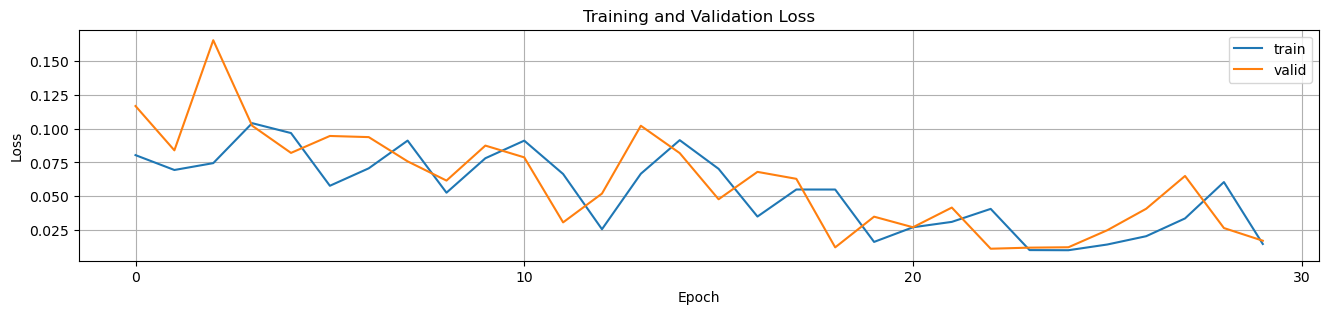

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(16, 3))
ax.plot(train_losses, label="train")
ax.plot(valid_losses, label="valid")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_xticks(np.arange(0, num_epochs+1, 10))
ax.set_xticklabels(np.arange(0, num_epochs+1, 10))
ax.set_ylabel("Loss")
ax.set_title("Training and Validation Loss")
ax.grid()
plt.show()

In [53]:
y_pred = rnn(torch.tensor(X_valid).to(device).unsqueeze(-1))
y_target = torch.tensor(y_valid).to(device).unsqueeze(-1)

# print(f"y_target shape: {y_target.shape}")
# print(f"y_pred shape: {y_pred.shape}")

print(f"Loss finale = {criterion(y_pred, y_target):.4e}")

y_pred = y_pred.cpu().detach().numpy()
y_target = y_target.cpu().detach().numpy()

# print(f"\n{np.mean(np.sqrt((y_target - y_pred) ** 2)):.4f} RMSE")

Loss finale = 1.7454e-02


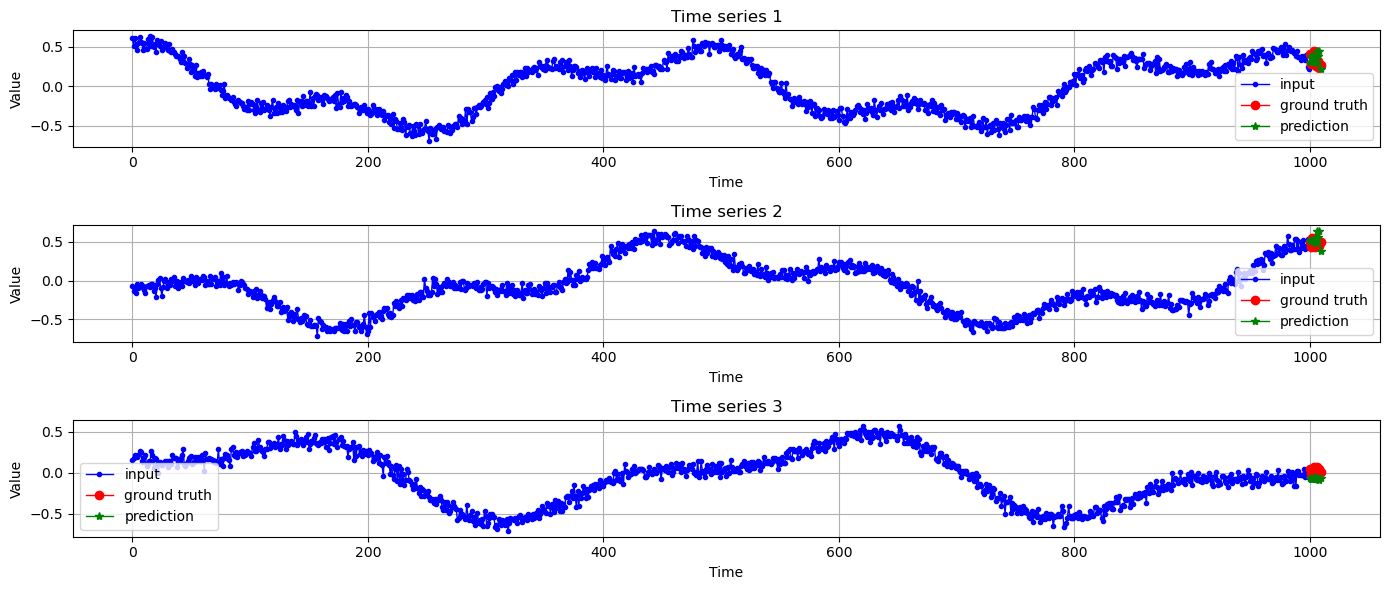

In [54]:
N = 3
fig, ax  = plt.subplots(N, 1, figsize=(14, 2 * N))
x_shift = X_valid.shape[-1]

for i in range(N):
    input = torch.tensor(X_valid[i], device=device).unsqueeze(0).unsqueeze(-1)
    # input = input.permute(1, 0, 2)  # permute to (seq_len, batch_size, input_dim)
    # print(f"input has shape {input.shape}")
    target = torch.tensor(y_valid[i], device=device).view(-1, n_ahead, 1)
    # target = target.permute(1, 0, 2)  # permute to (seq_len, batch_size, output_dim)
    # print(f"target has shape {target.shape}")
    output = rnn(input)
    output = output.cpu().detach().numpy()
    # print(f"output has shape {output.shape}")
    target = target.cpu().detach().numpy()
    
    ax[i].plot(input.squeeze().cpu().detach().numpy(), color='blue', marker=".", linewidth=1, label="input")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, target.squeeze(), color='red', marker="o", linewidth=1, label="ground truth")
    ax[i].plot(np.arange(len(target.squeeze()))+x_shift, output.squeeze(), color='green', marker="*", linewidth=1, label="prediction")
    ax[i].set_title(f"Time series {i+1}")
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel("Value")
    ax[i].legend()
    ax[i].grid(True)

plt.tight_layout()
plt.show()

# Training GP-VAE

https://www.youtube.com/watch?v=rz76gYgxySo&list=WL&index=1&t=1618s&ab_channel=SimonLeglaive

# Mettre à jour le jpg

<div>
<img src="/home/benjamin.deporte/MVA/MVA_Stage/vrnn3.jpg" width="1000"/>
</div>

# Training Pipeline

Parameters : univariate time series for now...

In [55]:
X_DIM = 1 # Dimension of the observation space
Z_DIM = 1 # Dimension of the latent space

Instantiating the model

In [56]:
encoder = Encoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

decoder = GaussianDecoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
).to(device)

prior = GaussianProcessPriorMaison().to(device)

print(encoder)
print()
print(decoder)
print()
print(prior)

Encoder(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
EncoderMean: EncoderMean(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
EncoderCovariance: EncoderCovariance(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)

GaussianDecoder(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
DecoderMean: DecoderMean(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
DecoderCovariance: DecoderCovariance(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)

GaussianProcessPriorMaison(kernel=GaussianKernel, mean_function=GPNullMean)
Kernel: GaussianKernel(lengthscale=1.0, variance=1.0)
Mean Function: GPNullMean(z_dimension=1)


Taking one time series

In [57]:
B = 16 # batch size
x = X_train[:B,:n_steps].reshape(B, n_steps, X_DIM)
x = torch.tensor(x, device=device) # (B, L, 1)
print(f"x shape: {x.shape}")

x shape: torch.Size([16, 1000, 1])


Encode Time Series

In [58]:
mu_phi, sigma_phi, q_phi = encoder(x)
print(f"mu_phi shape: {mu_phi.shape}")
print(f"sigma_phi shape: {sigma_phi.shape}")
print(f"q_phi: {q_phi}")
print(f"\tq_phi batch shape: {q_phi.batch_shape}")
print(f"\tq_phi event shape: {q_phi.event_shape}")

mu_phi shape: torch.Size([16, 1000])
sigma_phi shape: torch.Size([16, 1000, 1000])
q_phi: MultivariateNormal(loc: torch.Size([16, 1000]), covariance_matrix: torch.Size([16, 1000, 1000]))
	q_phi batch shape: torch.Size([16])
	q_phi event shape: torch.Size([1000])


Sample latent

In [59]:
z_sampled = q_phi.rsample()  # (B, L)
z_sampled = z_sampled.unsqueeze(2) # (B, L, 1)
print(f"z_sampled shape: {z_sampled.shape}")

z_sampled shape: torch.Size([16, 1000, 1])


Decode the latent and sample (lots of) x

In [60]:
mu_x, covar_x, p_theta_x = decoder(z_sampled)
print(f"mu_x shape: {mu_x.shape}")
print(f"covar_x shape: {covar_x.shape}")
print(f"p_theta_x: {p_theta_x}")
print(f"\tp_theta_x batch shape: {p_theta_x.batch_shape}")
print(f"\tp_theta_x event shape: {p_theta_x.event_shape}")

mu_x shape: torch.Size([16, 1000, 1])
covar_x shape: torch.Size([16, 1000, 1, 1])
p_theta_x: MultivariateNormal(loc: torch.Size([16, 1000, 1]), covariance_matrix: torch.Size([16, 1000, 1, 1]))
	p_theta_x batch shape: torch.Size([16, 1000])
	p_theta_x event shape: torch.Size([1])


In [61]:
K = 10 # number of samples to draw from the decoder distribution
x_hat = p_theta_x.rsample((K,))  # (K, B, L, 1)
print(f"x_hat shape: {x_hat.shape}")

x_hat shape: torch.Size([10, 16, 1000, 1])


Compute the Gaussian Process prior at times t's

In [62]:
t = torch.arange(n_steps, device=device).unsqueeze(0).unsqueeze(2)  # (1, L, 1)
t = t.repeat(B, 1, 1)  # (B, L, 1)
print(f"t shape: {t.shape}")
mu_z, sigma_z, p_theta_z = prior(t)
print(f"mu_z shape: {mu_z.shape}")
print(f"sigma_z shape: {sigma_z.shape}")
print(f"p_theta_z: {p_theta_z}")
print(f"\tp_theta_z batch shape: {p_theta_z.batch_shape}")
print(f"\tp_theta_z event shape: {p_theta_z.event_shape}")

t shape: torch.Size([16, 1000, 1])
mu_z shape: torch.Size([16, 1000, 1])
sigma_z shape: torch.Size([16, 1000, 1000])
p_theta_z: MultivariateNormal(loc: torch.Size([16, 1000]), covariance_matrix: torch.Size([16, 1000, 1000]))
	p_theta_z batch shape: torch.Size([16])
	p_theta_z event shape: torch.Size([1000])


Compute the metrics and the loss

In [63]:
kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = vlb(
    q_phi, p_theta_x, p_theta_z, x_hat
)

loss = -vlb_value
print(f"Loss : {loss.item():.4e}")

Loss : 3.7524e+48


# Full Training Loop

In [ ]:
encoder = Encoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
    activation=nn.ReLU,  # use tanh activation for the encoder
).to(device)

decoder = GaussianDecoder(
    sequence_length=n_steps,
    x_dimension=X_DIM,
    z_dimension=Z_DIM,
    activation=nn.ReLU,  # use tanh activation for the decoder
).to(device)

prior = GaussianProcessPriorMaison().to(device)

print(encoder)
print()
print(decoder)
print()
print(prior)
print()

B = 256 # batch size
x = X_train[:B,:n_steps].reshape(B, n_steps, X_DIM)
x = torch.tensor(x, device=device) # (B, L, 1)
print(f"x shape: {x.shape}")

t = torch.arange(n_steps, device=device).unsqueeze(0).unsqueeze(2)  # (1, L, 1)
t = t.repeat(B, 1, 1)  # (B, L, 1)
print(f"t shape: {t.shape}")

Encoder(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
EncoderMean: EncoderMean(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
EncoderCovariance: EncoderCovariance(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)

GaussianDecoder(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
DecoderMean: DecoderMean(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)
DecoderCovariance: DecoderCovariance(sequence_length=1000, x_dimension=1, z_dimension=1, n_layers=3, inter_dim=128, activation=ReLU)

GaussianProcessPriorMaison(kernel=GaussianKernel, mean_function=GPNullMean)
Kernel: GaussianKernel(lengthscale=1.0, variance=1.0)
Mean Function: GPNullMean(z_dimension=1)

x shape: torch.Size([512, 1000, 1])
t shape: torch.Size([512, 1000, 1])


In [65]:
# Training set up
optimizer = torch.optim.Adam(
    list(encoder.parameters()) + list(decoder.parameters()) + list(prior.parameters()),
    lr=1e-3
)

K = 10  # number of samples to draw from the decoder distribution

# Training loop
encoder.train()
decoder.train()
prior.train()

losses = []
kls_torch = []
kls_analytique = []
reconstruction_losses = []
kernel_lengthscales = []
kernel_variances = []
traces_sigma_q_phi = []
norms_mu_phi = []
norms_mu_x = []
traces_sigma_x = []
    
num_epochs = int(1.0e+3)

for i in range(num_epochs):
    
    # encode x
    mu_phi, sigma_phi, q_phi = encoder(x)
    
    # log q_phi caracteristics
    trace_sigma_q_phi = torch.einsum('bii->b', sigma_phi).mean()  # trace of the covariance matrix, used for diagnostics
    traces_sigma_q_phi.append(trace_sigma_q_phi.item())
    norm_mu_phi = torch.norm(mu_phi, dim=1).mean()  # mean of the norm of mu_phi
    norms_mu_phi.append(norm_mu_phi.item())
    
    # sample z
    z_sampled = q_phi.rsample()  # (B, L)
    z_sampled = z_sampled.unsqueeze(2)  # (B, L, 1)
    # decode z
    mu_x, covar_x, p_theta_x = decoder(z_sampled)
    
    # log p_theta_x caracteristics
    norm_mu_x = torch.norm(mu_x, dim=1).mean()  # mean of the norm of mu_x
    norms_mu_x.append(norm_mu_x.item())
    trace_sigma_x = torch.einsum('...ii->', covar_x).mean()  # trace of the covariance matrix, used for diagnostics
    traces_sigma_x.append(trace_sigma_x.item())
    
    # sample from p_theta_x
    xs_hat = p_theta_x.rsample((K,))  # (K, B, L, 1)
    
    # compute prior
    mu_z, sigma_z, p_theta_z = prior(t)
    
    # compute loss
    kl_divergence_torch, kl_divergence_analytique, reconstruction_loss, vlb_value = vlb(
        q_phi, p_theta_x, p_theta_z, xs_hat
    )
    loss = -vlb_value
    
    # add regularization on size of q_phi
    # size_of_q_phi = trace_sigma_q_phi + norm_mu_phi # compute the "size" of q_phi
    # loss += size_of_q_phi  # add regularization on size of q_phi
    
    # log losses
    losses.append(loss.item())
    kls_torch.append(kl_divergence_torch.item())
    kls_analytique.append(kl_divergence_analytique.item())
    # changing sign of reconstruction loss as it is an expectation of the log likelihood
    reconstruction_losses.append(-reconstruction_loss.item())
    # get kernel parameters, they are learnable
    kernel_lengthscale = prior.kernel.lengthscale.item()
    kernel_lengthscales.append(kernel_lengthscale)
    kernel_variance = prior.kernel.variance.item()
    kernel_variances.append(kernel_variance)
    
    # backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    # report out
    if (i+1) % 10 == 0:
        print(f"epoch {i+1:>4}/{num_epochs}, loss = {losses[-1]:.4e}, "
              f"kl_torch = {kls_torch[-1]:.4e}, "
              f"reconstruction_loss = {reconstruction_losses[-1]:.4e}, "
              f"GP kernel lengthscale = {kernel_lengthscale:.4e}, "
              f"GP kernel variance = {kernel_variance:.4e}"
              )

OutOfMemoryError: CUDA out of memory. Tried to allocate 3.82 GiB. GPU 0 has a total capacity of 23.64 GiB of which 104.56 MiB is free. Including non-PyTorch memory, this process has 23.53 GiB memory in use. Of the allocated memory 19.56 GiB is allocated by PyTorch, and 3.48 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
fig, ax = plt.subplots(1, 9, figsize=(36, 4))

ax[0].plot(losses, label="loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Total Loss")
ax[0].grid()
ax[0].legend()

ax[1].plot(kls_torch, label="kl_torch")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("KL")
ax[1].set_title("KL")
ax[1].grid()
ax[1].legend()

# ax[1].plot(kls_analytique, label="kl_analytique")
# ax[1].set_xlabel("Epoch")
# ax[1].set_ylabel("KL Divergence (analytique)")
# ax[1].set_title("KL Divergence (analytique) over epochs")
# ax[1].grid()
# ax[1].legend()

ax[2].plot(reconstruction_losses, label="reconstruction_loss")
ax[2].set_xlabel("Epoch")
ax[2].set_ylabel("Reconstruction Loss")
ax[2].set_title("Reconstruction Loss")
ax[2].grid()
ax[2].legend()

ax[3].plot(kernel_lengthscales, label="kernel_lengthscale")
ax[3].set_xlabel("Epoch")
ax[3].set_ylabel("Kernel Lengthscale")
ax[3].set_title("Kernel Lengthscale")
ax[3].grid()
ax[3].legend()

ax[4].plot(kernel_variances, label="kernel_variance")
ax[4].set_xlabel("Epoch")
ax[4].set_ylabel("Kernel Variance")
ax[4].set_title("Kernel Variance")
ax[4].grid()
ax[4].legend()

ax[5].plot(norms_mu_phi, label="norme_mu_phi (mean)")
ax[5].set_xlabel("Epoch")
ax[5].set_ylabel("Norme of Mu Phi")
ax[5].set_title("Norme of Mu Phi")
ax[5].grid()
ax[5].legend()

ax[6].plot(traces_sigma_q_phi, label="trace_sigma_q_phi (mean)")
ax[6].set_xlabel("Epoch")
ax[6].set_ylabel("Trace of Sigma Q Phi")
ax[6].set_title("Trace of Sigma Q Phi")
ax[6].grid()
ax[6].legend()

ax[7].plot(norms_mu_x, label="norme_mu_x (mean)")
ax[7].set_xlabel("Epoch")
ax[7].set_ylabel("Norme of Mu X")
ax[7].set_title("Norme of Mu X")
ax[7].grid()
ax[7].legend()

ax[8].plot(traces_sigma_x, label="trace_sigma_x (mean)")
ax[8].set_xlabel("Epoch")
ax[8].set_ylabel("Trace of Sigma X")
ax[8].set_title("Trace of Sigma X")
ax[8].grid()
ax[8].legend()

plt.show()